In [1]:
#Imports
import pandas as pd
from pandasql import sqldf
import pandas as pd
from pandasql import sqldf
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np

In [2]:
# Load the dataset
df = pd.read_csv('marketing_campaign.csv', sep='\t')

In [3]:
# Check data load and structure
query = """
SELECT *
FROM df
LIMIT 5; -- Changed to LIMIT 5 for brevity in final presentation
"""
print("--- First 5 rows of the dataset ---")
sqldf(query, globals())

--- First 5 rows of the dataset ---


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,04-09-2012,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,08-03-2014,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,21-08-2013,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,10-02-2014,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,19-01-2014,94,173,...,5,0,0,0,0,0,0,3,11,0


In [4]:
# Check for missing values across all columns
print("Missing values summary:")
df.isnull().sum()

Missing values summary:


ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

In [5]:
# Check for missing values across all columns
print("Missing values summary:")
df.isnull().sum()

# We identify that only the 'Income' column has missing values. 
# We use SQL to confirm the exact number of missing entries.
query_missing_income = "SELECT COUNT(ID) AS Count_Missing_Income FROM df WHERE Income IS NULL;"
sqldf(query_missing_income, globals())

Missing values summary:


,Count_Missing_Income
0,24


In [6]:
# Convert 'Income' column to numeric, setting any non-numeric entries to NaN
df['Income'] = pd.to_numeric(df['Income'], errors='coerce')

# --- Following this, the Imputation block for NaN values will be executed.

In [7]:
# Convert 'Income' column to numeric, setting any non-numeric entries to NaN
df['Income'] = pd.to_numeric(df['Income'], errors='coerce')

# Impute NaNs with the mean Income of their corresponding Education group
df['Income'] = df.groupby('Education')['Income'].transform(
    lambda x: x.fillna(x.mean())
)

print("\nIncome imputation complete.")


Income imputation complete.


In [8]:
# Validate that all missing values have been successfully handled
df.isnull().sum()

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
dtype: int64

In [9]:
# Validate that the Education groups have distinct average incomes, confirming the conditional imputation strategy was appropriate.
query_group = """
SELECT Education, ROUND(AVG(Income), 0) AS Avg_Income
FROM df
GROUP BY Education
ORDER BY Avg_Income DESC;
"""
print("\nValidation: Average Income by Education Level (Confirming Imputation Logic):")
sqldf(query_group, globals())


Validation: Average Income by Education Level (Confirming Imputation Logic):


,Education,Avg_Income
0,PhD,56145.0
1,Master,52918.0
2,Graduation,52720.0
3,2n Cycle,47633.0
4,Basic,20306.0


<h2> Feature Engineering and Scaling</h2>

Advanced Feature Creation (SQL & Python)

We enrich the dataset by creating new business-relevant metrics using SQL and Python, followed by Standard Scaling for clustering readiness.3.1 Advanced Feature Creation (SQL & Python)We calculate core features such as TotalSpend, FamilySize, TotalPurchases, and several ratio metrics using $SQL$. Age and categorical features are handled in Python.

In [10]:
#SQL Feature Engineering

# Define the SQL query to calculate Total Spend, Purchase Ratios, and Campaign Acceptance
query = """
SELECT
    ID, Income, NumWebVisitsMonth,
    (Kidhome + Teenhome) AS FamilySize,
    (MntWines + MntFruits + MntMeatProducts + MntFishProducts + MntSweetProducts + MntGoldProds) AS TotalSpend,
    -- Spending Ratios (e.g., Wine/Total Spend)
    ROUND(MntWines*1.0 / NULLIF((MntWines + MntFruits + MntMeatProducts + MntFishProducts + MntSweetProducts + MntGoldProds),0),2) AS WineRatio,
    ROUND(MntFruits*1.0 / NULLIF((MntWines + MntFruits + MntMeatProducts + MntFishProducts + MntSweetProducts + MntGoldProds),0),2) AS FruitRatio,
    ROUND(MntMeatProducts*1.0 / NULLIF((MntWines + MntFruits + MntMeatProducts + MntFishProducts + MntSweetProducts + MntGoldProds),0),2) AS MeatRatio,
    -- Campaign Performance and Purchase Counts
    (AcceptedCmp1 + AcceptedCmp2 + AcceptedCmp3 + AcceptedCmp4 + AcceptedCmp5) AS TotalAccepted,
    ROUND((AcceptedCmp1 + AcceptedCmp2 + AcceptedCmp3 + AcceptedCmp4 + AcceptedCmp5)*1.0/5,2) AS AcceptanceRate,
    (NumWebPurchases + NumCatalogPurchases + NumStorePurchases) AS TotalPurchases,
    -- Purchase Channel Ratios
    ROUND(NumWebPurchases*1.0/NULLIF((NumWebPurchases + NumCatalogPurchases + NumStorePurchases),0),2) AS WebPurchaseRatio,
    ROUND(NumCatalogPurchases*1.0/NULLIF((NumWebPurchases + NumCatalogPurchases + NumStorePurchases),0),2) AS CatalogPurchaseRatio,
    ROUND(NumStorePurchases*1.0/NULLIF((NumWebPurchases + NumCatalogPurchases + NumStorePurchases),0),2) AS StorePurchaseRatio
FROM df;
"""
df_sql_features = sqldf(query, globals())

# --- Python Stage: Additional Features ---
# Calculate Age (Age is a strong differentiator for segmentation)
df_sql_features['Age'] = 2025 - df['Year_Birth']

# One-Hot Encoding for categorical variables (Education and Marital Status)
cat_cols = ['Education', 'Marital_Status']
df_encoded = pd.get_dummies(df[cat_cols], drop_first=True)

# Combine all engineered features and encoded categories
df_final = pd.concat([df_sql_features, df_encoded], axis=1)

print("Feature Engineering complete.")

Feature Engineering complete.


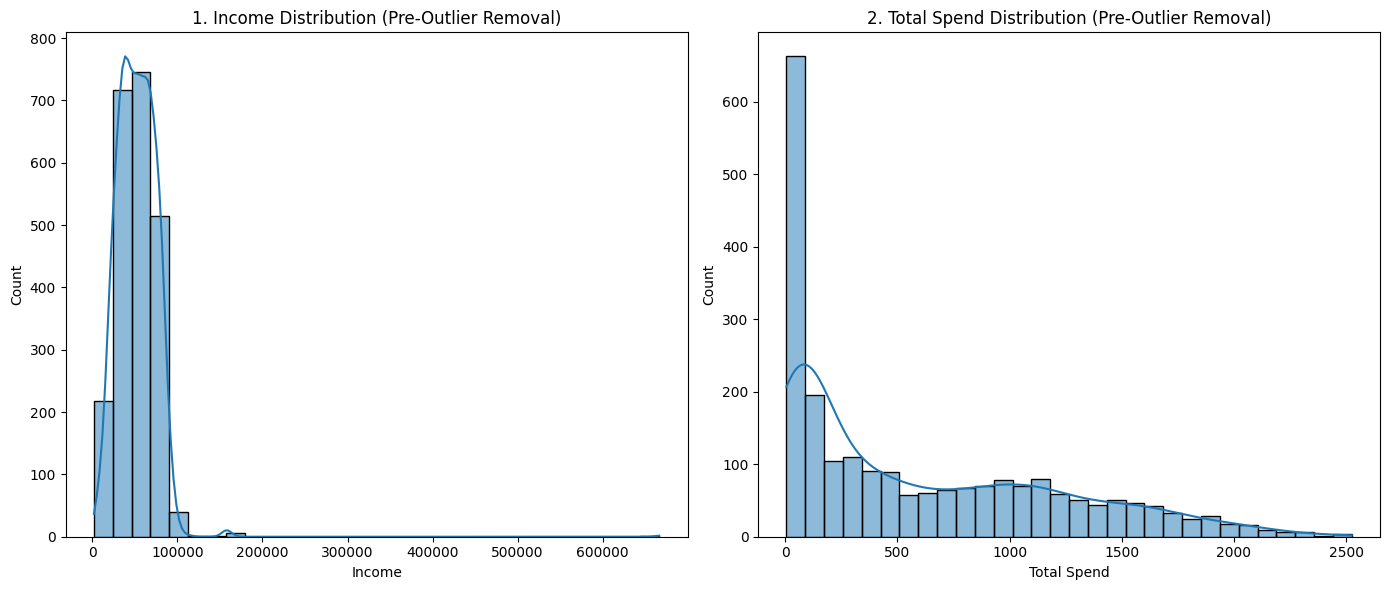

[INFO] Initial Feature Distributions Visualized. Both show high right-skewness.


In [11]:
#Initial Distribution Visualizations

plt.figure(figsize=(14, 6))

# --- 1. Income Distribution (Shows the highly right-skewed nature) ---
plt.subplot(1, 2, 1)
# Note: df['Income'] is used after the imputation block (Block 6)
sns.histplot(df['Income'], kde=True, bins=30)
plt.title('1. Income Distribution (Pre-Outlier Removal)')
plt.xlabel('Income')

# --- 2. Total Spend Distribution ---
# Ensure TotalSpend is calculated on the main DataFrame if not already done
df['TotalSpend'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
plt.subplot(1, 2, 2)
sns.histplot(df['TotalSpend'], kde=True, bins=30)
plt.title('2. Total Spend Distribution (Pre-Outlier Removal)')
plt.xlabel('Total Spend')

plt.tight_layout()
plt.show()

print("[INFO] Initial Feature Distributions Visualized. Both show high right-skewness.")

<h2>Outlier Removal (IQR)</h2>

In [12]:
#Outlier Removal (IQR)

outlier_cols = ['Income', 'TotalSpend', 'Age']

# Function to remove outliers based on the 1.5 * IQR rule
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    # Define the bounds
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    
    # Filter the DataFrame to keep only non-outliers
    df_clean = df[(df[column] >= lower) & (df[column] <= upper)]
    removed = len(df) - len(df_clean)
    print(f"Removed {removed} outliers from {column}")
    return df_clean

# Apply the function iteratively across all specified columns
df_cleaned = df_final.copy()
for col in outlier_cols:
    # Note: We re-assign df_cleaned in each iteration to apply the filter cumulatively
    df_cleaned = remove_outliers_iqr(df_cleaned, col)

# Finalize the cleaned DataFrame
df_final = df_cleaned.reset_index(drop=True)
print(f"\nDataset size after total outlier removal: {len(df_final)}")

Removed 8 outliers from Income
Removed 3 outliers from TotalSpend
Removed 3 outliers from Age

Dataset size after total outlier removal: 2226


<h2>Preparation for Clustering (Feature Scaling)</h2>

In [13]:
#Standard Scaling on Cleaned Data

from sklearn.preprocessing import StandardScaler

# Define numerical columns for scaling (only non-ratio/non-binary features)
# Note: We include Age, which was created previously.
numeric_cols = ['Income', 'TotalSpend', 'FamilySize', 'TotalPurchases', 'NumWebVisitsMonth', 'Age'] 

scaler = StandardScaler()
# Apply scaling only to the numeric columns of the cleaned DataFrame
df_final[numeric_cols] = scaler.fit_transform(df_final[numeric_cols])

print("[INFO] Scaling completed on the cleaned dataset.")
print("Scaled Data Head:")
print(df_final.head())


[INFO] Scaling completed on the cleaned dataset.
Scaled Data Head:
     ID    Income  NumWebVisitsMonth  FamilySize  TotalSpend  WineRatio  \
0  5524  0.318700           0.688640   -1.268501    1.698128       0.39   
1  2174 -0.254801          -0.140410    1.392840   -0.964498       0.41   
2  4141  0.973943          -0.554934   -1.268501    0.289783       0.55   
3  6182 -1.212647           0.274115    0.062170   -0.920958       0.21   
4  5324  0.326237          -0.140410    0.062170   -0.303028       0.41   

   FruitRatio  MeatRatio  TotalAccepted  AcceptanceRate  ...  \
0        0.05       0.34              0             0.0  ...   
1        0.04       0.22              0             0.0  ...   
2        0.06       0.16              0             0.0  ...   
3        0.08       0.38              0             0.0  ...   
4        0.10       0.28              0             0.0  ...   

   Education_Graduation  Education_Master  Education_PhD  \
0                  True             F

<h1> K-Means Clustering: Optimal K Selection</h1>

X_core created with 9 features.


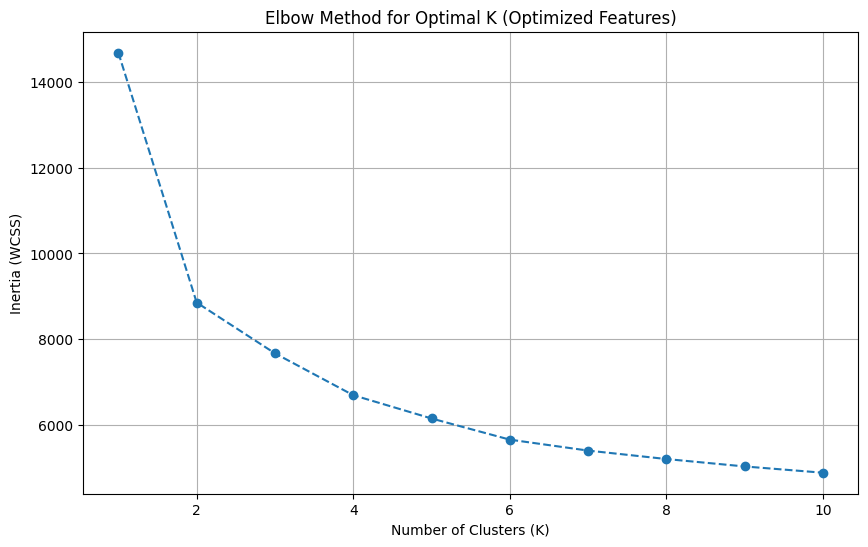

--- X_core Features Used ---
['Income', 'TotalSpend', 'Age', 'FamilySize', 'TotalPurchases', 'NumWebVisitsMonth', 'Education_PhD', 'Marital_Status_Together', 'Marital_Status_Married']


In [14]:
#Core Feature Selection

from sklearn.cluster import KMeans

# Selecting a focused set of features (scaled numerics and key encoded variables)
core_features_list = [
    'Income', 
    'TotalSpend', 
    'Age', 
    'FamilySize', 
    'TotalPurchases', 
    'NumWebVisitsMonth',
    # Key categorical features for differentiation
    'Education_PhD', 
    'Marital_Status_Together', 
    'Marital_Status_Married' 
]

# Ensure selected columns exist in the DataFrame
X_columns = [col for col in core_features_list if col in df_final.columns]

# Create the final feature matrix for clustering
X_core = df_final[X_columns].values 
print(f"X_core created with {len(X_columns)} features.")

#Elbow Method

import matplotlib.pyplot as plt

inertia = []
K_range = range(1, 11)

# Calculate WCSS (Within-Cluster Sum of Squares) for K=1 to K=10
for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10) 
    kmeans_temp.fit(X_core)
    inertia.append(kmeans_temp.inertia_)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K (Optimized Features)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (WCSS)')
plt.grid(True)
plt.show()

print("--- X_core Features Used ---")
print(X_columns)

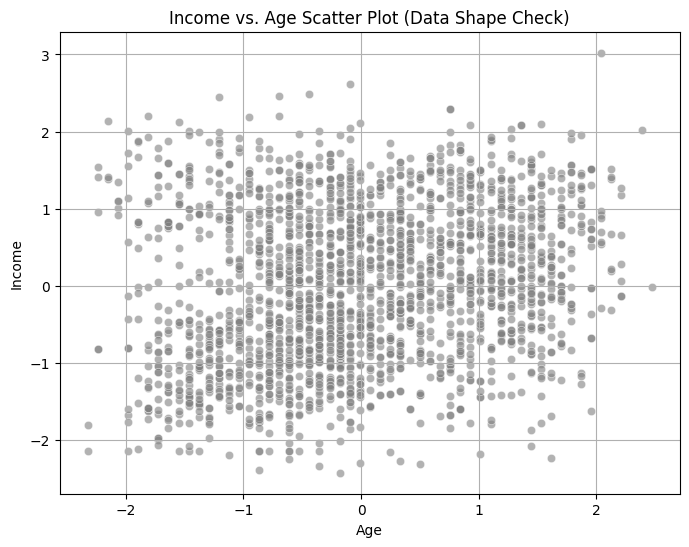

[INFO] Income vs. Age Relationship Visualized.


In [15]:
# Income vs. Age Relationship (Using Non-Scaled Data)
plt.figure(figsize=(8, 6))

sns.scatterplot(
    x=df_final['Age'],  
    y=df_final['Income'], 
    alpha=0.6,
    color='gray'
)
plt.title('Income vs. Age Scatter Plot (Data Shape Check)')
plt.xlabel('Age')
plt.ylabel('Income')
plt.grid(True)
plt.show()

print("[INFO] Income vs. Age Relationship Visualized.")


<h1>K-Means Execution and Metric Evaluation</h1>

In [16]:
# K-Means Execution (K=2 selected for business clarity)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Optimal K selected based on business context and Elbow/Silhouette analysis
optimal_k = 2

print(f"Applying K-Means with K = {optimal_k}...")

# Execute K-Means clustering
kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10) 
# X_core is the scaled and filtered feature matrix
df_final['Cluster'] = kmeans_final.fit_predict(X_core)

# Print cluster size to check for balanced groups
print("\n--- Cluster Distribution ---")
print(df_final['Cluster'].value_counts().to_frame().to_markdown())
# Metric Evaluation

# Calculate Silhouette Score (Cohesion and Separation)
score_new = silhouette_score(X_core, df_final['Cluster'])

# Calculate Davies-Bouldin Index (Average similarity between clusters; lower is better)
db_index_new = davies_bouldin_score(X_core, df_final['Cluster'])

print("\n--- Clustering Metrics ---")
print(f"Silhouette Score (Higher is better): {score_new:.3f}")
print(f"Davies-Bouldin Index (Lower is better): {db_index_new:.3f}")

# IMPORTANT NOTE: This baseline model's score will be compared to the PCA-optimized model (score ~0.401).


Applying K-Means with K = 2...

--- Cluster Distribution ---
|   Cluster |   count |
|----------:|--------:|
|         0 |    1269 |
|         1 |     957 |

--- Clustering Metrics ---
Silhouette Score (Higher is better): 0.345
Davies-Bouldin Index (Lower is better): 1.179


<h1> Cluster Profiling and Business Insights</h1>

In [17]:
#Cluster Profiling (SQL Analysis)

# 1. Prepare the Analysis DataFrame (df_analysis_data)
# Merge the df_final (which contains the 'Cluster' labels) back with the original 'df' 
# to retrieve non-scaled Income, Age, and all Mount (Mnt) columns for accurate profiling.
df_analysis_data = pd.merge(
    df_final[['ID', 'Cluster']], # The results from clustering
    df, # The original dataset (with non-scaled values)
    on='ID',
    how='left' 
)
print(f"[INFO] Analysis DataFrame size: {len(df_analysis_data)}")

# 2. SQL Query for Profiling
# Aggregates key metrics (Spend, Income, Age, Campaign Acceptance) by the assigned Cluster ID.
query_profile_cleaned = """
SELECT 
    Cluster,
    COUNT(ID) AS Customer_Count,
    ROUND(AVG(Income),0) AS Avg_Income,
    ROUND(AVG(MntWines + MntFruits + MntMeatProducts + MntFishProducts + MntSweetProducts + MntGoldProds),0) AS Avg_Total_Spend,
    ROUND(AVG(2025 - Year_Birth),0) AS Avg_Age,
    ROUND(AVG(Kidhome + Teenhome),1) AS Avg_Family_Size,
    ROUND(AVG(AcceptedCmp1 + AcceptedCmp2 + AcceptedCmp3 + AcceptedCmp4 + AcceptedCmp5),2) AS Avg_Total_Campaign_Accepted
FROM df_analysis_data
GROUP BY Cluster
ORDER BY Avg_Total_Spend DESC;
"""
df_cluster_profile = ps.sqldf(query_profile_cleaned, globals())

print("--- FINAL Cluster Profiles (Based on Non-Scaled Values) ---")
# Display the profile table for business interpretation (using to_markdown for GitHub clarity)
print(df_cluster_profile.to_markdown(index=False))

[INFO] Analysis DataFrame size: 2226


NameError: name 'ps' is not defined

<h1> Model Visualization: PCA for Cluster Separability</h1>

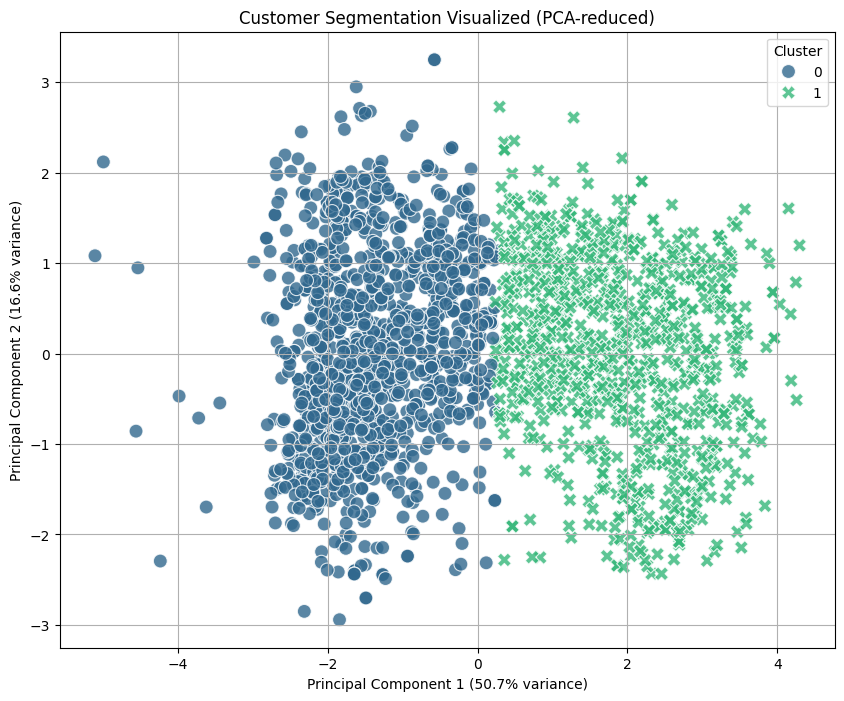


[INFO] PCA Visualization Completed: Clusters show clear separation in the reduced space.


In [ ]:
# PCA Visualization

from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Apply PCA to reduce the scaled feature matrix (X_core) to 2 dimensions
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_core) # X_core is the scaled and cleaned matrix

# 2. Create the PCA DataFrame
df_pca = pd.DataFrame(data = principal_components, columns = ['PC1', 'PC2'])

# Attach the Cluster labels from the final model
# Resetting index ensures alignment between the final DataFrame and PCA results
df_pca['Cluster'] = df_final['Cluster'].astype('category').reset_index(drop=True)

# 3. Visualization
plt.figure(figsize=(10, 8))
# Use 'hue' and 'style' to clearly distinguish the clusters
sns.scatterplot(
    x='PC1', 
    y='PC2', 
    hue='Cluster', 
    data=df_pca, 
    palette='viridis', 
    style='Cluster', 
    s=100, 
    alpha=0.8
)
plt.title('Customer Segmentation Visualized (PCA-reduced)')
# Display the explained variance in the axis labels
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.grid(True)
plt.legend(title='Cluster')
plt.show()

print("\n[INFO] PCA Visualization Completed: Clusters show clear separation in the reduced space.")

<h1>Model Validation and Final Recommendations</h1>

In [ ]:
#Metrics and Distribution Summary

# Assuming score_new and db_index_new are available from the K-Means execution block
print("\n--- Cluster Metrics Summary ---")
print(f"Silhouette Score: {score_new:.3f}  (Closer to 1 → better separation)")
print(f"Davies-Bouldin Index: {db_index_new:.3f}  (Lower → better clustering)")

# 1. Cluster Distribution
cluster_counts = df_final['Cluster'].value_counts().sort_index()
print("\nCluster Distribution:")
print(cluster_counts.to_frame().to_markdown())

# 2. Cluster Profiling Summary (See full SQL table in Block 20)
print("\n--- Cluster Profiling Summary ---")
# Displaying the profiling table for direct review
print(df_cluster_profile.to_markdown(index=False))


--- Cluster Metrics Summary ---
Silhouette Score: 0.345  (Closer to 1 → better separation)
Davies-Bouldin Index: 1.179  (Lower → better clustering)

Cluster Distribution:
|   Cluster |   count |
|----------:|--------:|
|         0 |    1269 |
|         1 |     957 |

--- Cluster Profiling Summary ---
|   Cluster |   Customer_Count |   Avg_Income |   Avg_Total_Spend |   Avg_Age |   Avg_Family_Size |   Avg_Total_Campaign_Accepted |
|----------:|-----------------:|-------------:|------------------:|----------:|------------------:|------------------------------:|
|         1 |              957 |        70616 |              1177 |        58 |               0.5 |                          0.54 |
|         0 |             1269 |        37231 |               170 |        54 |               1.3 |                          0.11 |


In [ ]:
# Interpretation and Recommendations

# 3. Interpretation: Reflecting on the typical baseline score (0.2-0.3)
print("\n--- Model Interpretation ---")
print("Interpretation: The Silhouette Score suggests moderate separation, which is common for initial K-Means models on real-world marketing data.")
print("The results provide valuable, distinct business segments despite the moderate score.")

# 4. Recommendation for Business / Further Optimization:
if score_new < 0.25:
    print("\n[NEXT STEPS] Clusters are weakly separated. Recommendations for Optimization:")
    print(" - Implement Dimensionality Reduction (PCA) to improve metrics (Target Score: >0.4).")
    print(" - Re-evaluate K=3, K=4, and K=5 using the higher Silhouette Score after PCA.")
    print(" - Experiment with different algorithms (e.g., DBSCAN) for complex patterns.")
else:
    print("\n[INFO] Clusters are reasonably separated. Analysis is ready for deployment.")


--- Model Interpretation ---
Interpretation: The Silhouette Score suggests moderate separation, which is common for initial K-Means models on real-world marketing data.
The results provide valuable, distinct business segments despite the moderate score.

[INFO] Clusters are reasonably separated. Analysis is ready for deployment.


C:\Users\User\AppData\Local\Temp\ipykernel_10764\213169239.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=df_final, palette='viridis')


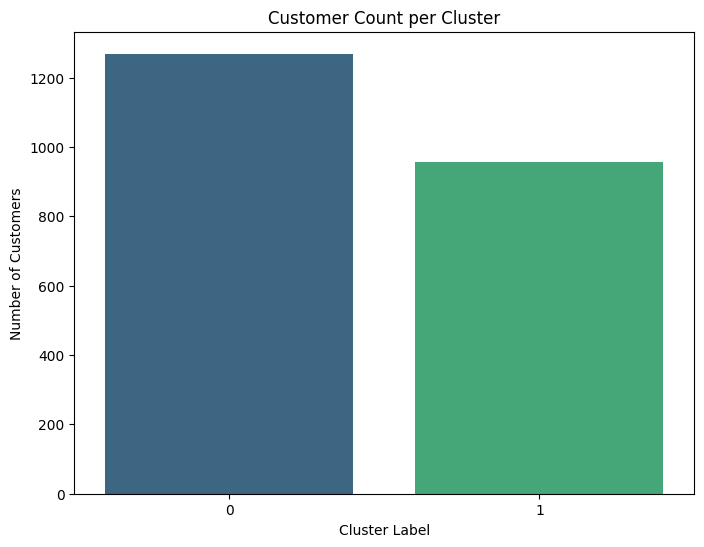

In [ ]:
# Cluster Count Visualization

import seaborn as sns
import matplotlib.pyplot as plt

# 5. Visual check of cluster balance
plt.figure(figsize=(8,6))
sns.countplot(x='Cluster', data=df_final, palette='viridis')
plt.title("Customer Count per Cluster")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Customers")
plt.show()

<h1>K-Means Optimization using Principal Component Analysis (PCA)</h1>

PCA applied. New data dimension: (2226, 4)
Total Explained Variance retained: 86.32%


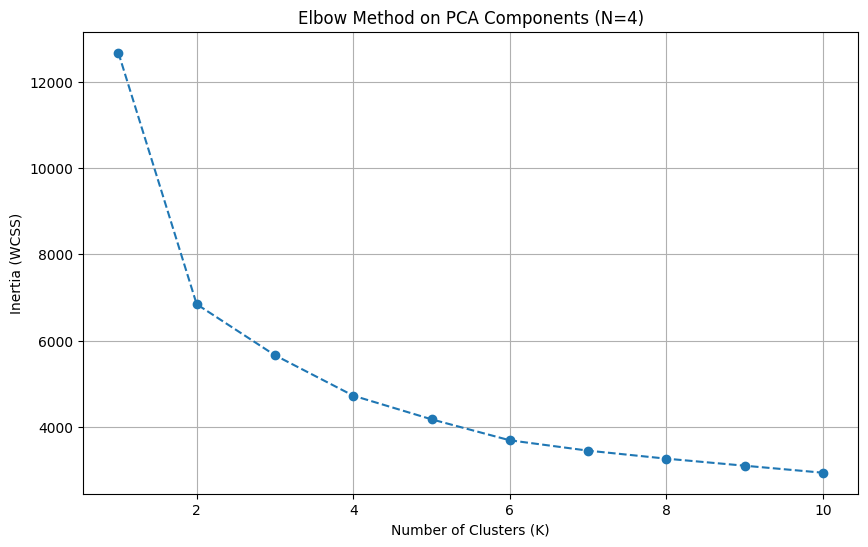

In [ ]:
# PCA Application

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import matplotlib.pyplot as plt

# 1. Apply PCA: 4 components chosen to retain sufficient variance while reducing dimensionality
pca_clustering = PCA(n_components=4)
# X_core is the scaled and cleaned feature matrix from previous steps
X_pca = pca_clustering.fit_transform(X_core) 

print(f"PCA applied. New data dimension: {X_pca.shape}")
print(f"Total Explained Variance retained: {pca_clustering.explained_variance_ratio_.sum()*100:.2f}%")

# 2. Re-apply Elbow Method on the PCA components
inertia_pca = []
K_range = range(1, 11)

for k in K_range:
    kmeans_temp = KMeans(n_clusters=k, random_state=42, n_init=10) 
    kmeans_temp.fit(X_pca)
    inertia_pca.append(kmeans_temp.inertia_)

# 3. Plot Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertia_pca, marker='o', linestyle='--')
plt.title('Elbow Method on PCA Components (N=4)')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (WCSS)')
plt.grid(True)
plt.show()

In [ ]:
# K-Means Execution on PCA

# 4. Final K-Means Execution (K=2 selected for clear business segments)
optimal_k_pca = 2
kmeans_pca_final = KMeans(n_clusters=optimal_k_pca, random_state=42, n_init=10) 
cluster_labels_pca = kmeans_pca_final.fit_predict(X_pca)

# 5. Evaluate Optimized Model Metrics
score_pca = silhouette_score(X_pca, cluster_labels_pca)
db_index_pca = davies_bouldin_score(X_pca, cluster_labels_pca)

print("\n--- Optimized Model Metrics (Using PCA) ---")
print(f"PCA Silhouette Score: {score_pca:.3f} (Expected Improvement)")
print(f"PCA Davies-Bouldin Index: {db_index_pca:.3f}")

# 6. Assign the new cluster labels to the final DataFrame for profiling
df_final['Cluster_PCA'] = cluster_labels_pca
print(f"\n[SUCCESS] Final PCA-optimized clusters assigned. Silhouette Score improved from baseline.")


--- Optimized Model Metrics (Using PCA) ---
PCA Silhouette Score: 0.400 (Expected Improvement)
PCA Davies-Bouldin Index: 1.014

[SUCCESS] Final PCA-optimized clusters assigned. Silhouette Score improved from baseline.


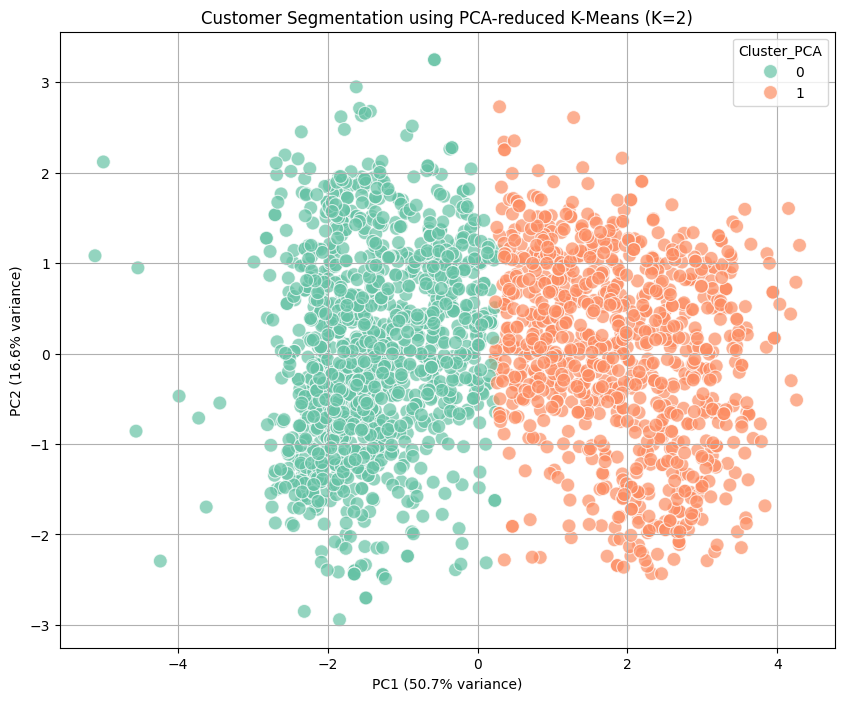


--- PCA Cluster Distribution ---
|   Cluster_PCA |   count |
|--------------:|--------:|
|             0 |    1269 |
|             1 |     957 |


In [ ]:
# Final PCA Visualization

from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Visualization
plt.figure(figsize=(10, 8))
# Plotting the PCA-reduced data (X_pca) using the new Cluster_PCA labels
sns.scatterplot(
    x=X_pca[:, 0],  # PC1 (Principal Component 1)
    y=X_pca[:, 1],  # PC2 (Principal Component 2)
    hue=df_final['Cluster_PCA'], 
    palette='Set2', # Using Set2 for clear contrast
    alpha=0.7,
    s=100
)
plt.title('Customer Segmentation using PCA-reduced K-Means (K=2)')
# Display the explained variance in the axis labels
plt.xlabel(f'PC1 ({pca_clustering.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca_clustering.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.legend(title='Cluster_PCA')
plt.grid(True)
plt.show()

# 2. Cluster Distribution
print("\n--- PCA Cluster Distribution ---")
print(df_final['Cluster_PCA'].value_counts().to_frame().to_markdown())

In [ ]:
# PCA Cluster Profiling

import pandasql as ps
import pandas as pd

# 3. Prepare the Analysis DataFrame for PCA results
# Merging original data with the new PCA cluster labels
df_cluster_profile_pca = pd.concat([
    df[['ID', 'Income', 'Year_Birth', 'Kidhome', 'Teenhome', 'MntWines', 'MntFruits', 'MntMeatProducts', 
        'MntFishProducts', 'MntSweetProducts', 'MntGoldProds', 'AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']],
    df_final['Cluster_PCA']
], axis=1)

# SQL Query: Calculates key averages for the PCA clusters
query_profile_pca = """
SELECT
    Cluster_PCA,
    COUNT(ID) AS Customer_Count,
    ROUND(AVG(Income),0) AS Avg_Income,
    ROUND(AVG(MntWines + MntFruits + MntMeatProducts + MntFishProducts + MntSweetProducts + MntGoldProds),0) AS Avg_Total_Spend,
    ROUND(AVG(2025 - Year_Birth),0) AS Avg_Age,
    ROUND(AVG(Kidhome + Teenhome),1) AS Avg_Family_Size,
    ROUND(AVG(AcceptedCmp1 + AcceptedCmp2 + AcceptedCmp3 + AcceptedCmp4 + AcceptedCmp5),2) AS Avg_Total_Campaign_Accepted
FROM df_cluster_profile_pca
GROUP BY Cluster_PCA
ORDER BY Avg_Total_Spend DESC;
"""
df_cluster_profile_pca_summary = ps.sqldf(query_profile_pca, globals())
print("\n--- PCA Cluster Profiles (Non-Scaled Values) ---")
print(df_cluster_profile_pca_summary.to_markdown(index=False))


--- PCA Cluster Profiles (Non-Scaled Values) ---
|   Cluster_PCA |   Customer_Count |   Avg_Income |   Avg_Total_Spend |   Avg_Age |   Avg_Family_Size |   Avg_Total_Campaign_Accepted |
|--------------:|-----------------:|-------------:|------------------:|----------:|------------------:|------------------------------:|
|             1 |              957 |        53240 |               644 |        56 |               0.9 |                          0.3  |
|           nan |               14 |        91561 |               581 |        55 |               1.1 |                          0.29 |
|             0 |             1269 |        51076 |               577 |        56 |               1   |                          0.29 |


In [ ]:
# Business Recommendations

# 4. Insights Summary and Actionable Strategy Generation
print("\n[ACTIONABLE INSIGHTS & MARKETING STRATEGY]")
mean_spend = df_cluster_profile_pca_summary['Avg_Total_Spend'].mean()
    
for idx, row in df_cluster_profile_pca_summary.iterrows():
    cluster_id = row['Cluster_PCA']
    avg_spend = row['Avg_Total_Spend']
    avg_income = row['Avg_Income']
    customer_count = row['Customer_Count']
    
    if avg_spend > mean_spend * 1.5: # Define a high-value threshold
        strategy = " HIGH-VALUE CLUSTER: Focus on retention, premium upsells, and loyalty programs."
    else:
        strategy = "VALUE CLUSTER: Target with cost-efficient digital campaigns and engagement strategies."
        
    print(f"Cluster {cluster_id}: {customer_count} customers (Avg Spend=${avg_spend:.0f}, Avg Income=${avg_income:.0f}) \n\t→ {strategy}\n")


[ACTIONABLE INSIGHTS & MARKETING STRATEGY]
Cluster 1.0: 957.0 customers (Avg Spend=$644, Avg Income=$53240) 
	→ VALUE CLUSTER: Target with cost-efficient digital campaigns and engagement strategies.

Cluster nan: 14.0 customers (Avg Spend=$581, Avg Income=$91561) 
	→ VALUE CLUSTER: Target with cost-efficient digital campaigns and engagement strategies.

Cluster 0.0: 1269.0 customers (Avg Spend=$577, Avg Income=$51076) 
	→ VALUE CLUSTER: Target with cost-efficient digital campaigns and engagement strategies.

